In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # Adjust the path to the parent directory of 'source' if necessary
from source.preprocessing import DataPreprocessor
from source.studentGrouping import StudentGrouping
import networkx as nx
from sklearn.metrics import silhouette_score
import seaborn as sns

In [26]:
filePATH = "../data/raw/personalized_learning_dataset.csv"
df = pd.read_csv(filePATH)

In [27]:
import os
print("Current working directory:", os.getcwd())
preprocessor = DataPreprocessor(df=df)
df = preprocessor.encodeCategorical()

Current working directory: d:\EvolveEd\notebooks


In [28]:
grouping = StudentGrouping(df)

In [ ]:
AgglomerativeLabels = grouping.clusterStudents(algorithm = "Agglomerative", n_clusters = 4)
KMeansLabels = grouping.clusterStudents(algorithm = "KMeans", n_clusters = 4, random_state = 42)
DBSCANLabels = grouping.clusterStudents(algorithm = "DBSCAN", eps = 0.5, min_samples = 5) 

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pcaResult = pca.fit_transform(df.drop(columns=['Student_ID']))

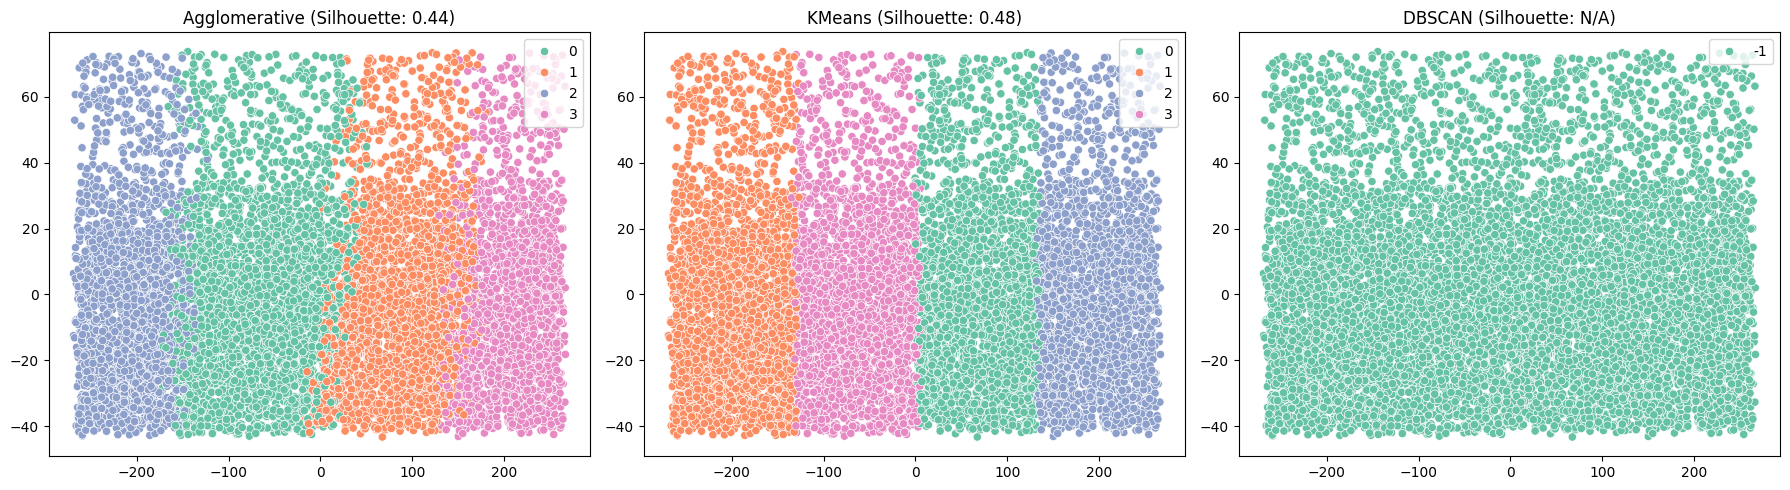

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
algorithms = ['Agglomerative', 'KMeans', 'DBSCAN']
labels_list = [AgglomerativeLabels, KMeansLabels, DBSCANLabels]

for ax, title, labels in zip(axes, algorithms, labels_list):
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:  # Exclude DBSCAN noise if present
        score = silhouette_score(pcaResult, labels)
        title += f' (Silhouette: {score:.2f})'
    else:
        title += ' (Silhouette: N/A)'
    
    sns.scatterplot(x=pcaResult[:, 0], y=pcaResult[:, 1], hue=labels, palette='Set2', ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

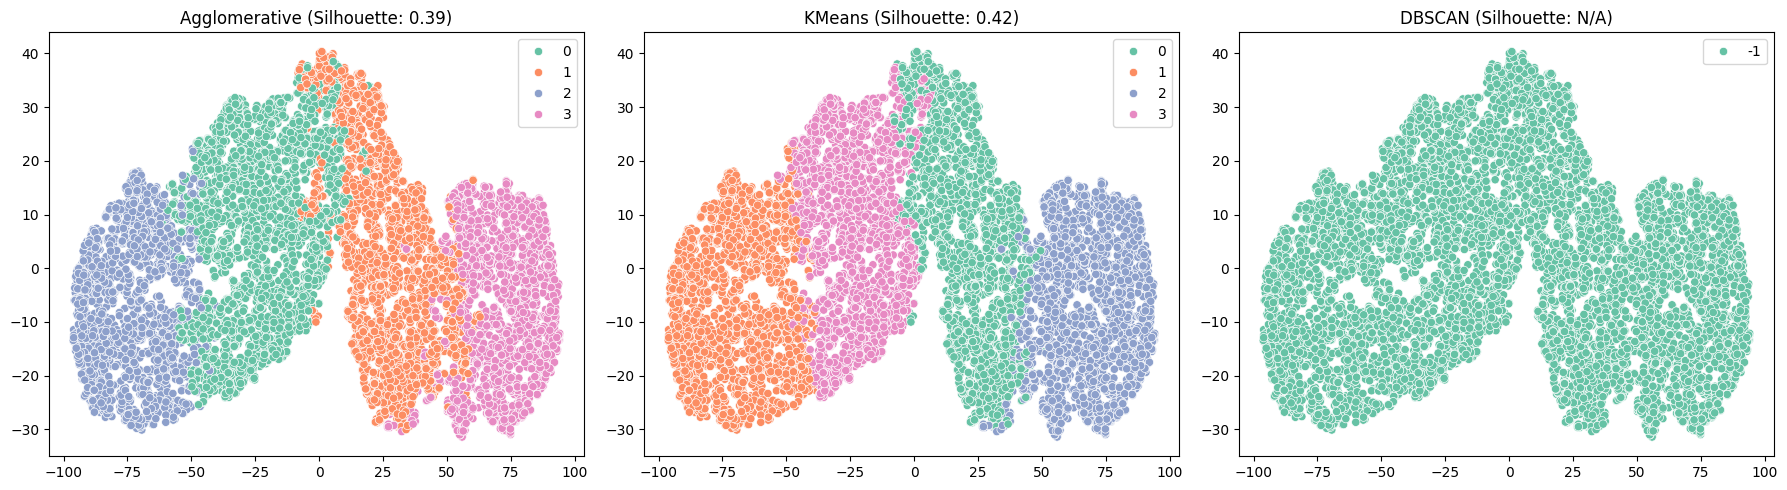

In [32]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, max_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(df.drop(columns=['Student_ID']))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, title, labels in zip(axes, algorithms, labels_list):
    # Compute Silhouette Score (only if >1 cluster exists)
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:  # Exclude DBSCAN noise if present
        score = silhouette_score(tsne_result, labels)
        title += f' (Silhouette: {score:.2f})'
    else:
        title += ' (Silhouette: N/A)'
    
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='Set2', ax=ax)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [33]:
df['Avg_Quiz_Score_Per_Attempt'] = df['Quiz_Scores'] / df['Quiz_Attempts'].replace(0, 1)
df['Engagement_Score'] = 0.4 * df['Time_Spent_on_Videos'] + 0.3 * df['Forum_Participation'] + 0.3 * df['Assignment_Completion_Rate']
df['Video_Efficiency'] = df['Quiz_Scores'] / df['Time_Spent_on_Videos'].replace(0, 1)
df['Consistency_Index'] = abs(df['Quiz_Scores'] - df['Final_Exam_Score'])  # As a proxy

In [34]:
cluster_configs = {
    "Engagement": ['Time_Spent_on_Videos', 'Forum_Participation', 'Assignment_Completion_Rate', 'Engagement_Score'],
    "Performance": ['Quiz_Scores', 'Quiz_Attempts', 'Final_Exam_Score', 'Avg_Quiz_Score_Per_Attempt'],
    "LearningStyle_Behavior": ['Learning_Style', 'Time_Spent_on_Videos', 'Dropout_Likelihood', 'Feedback_Score'],
    "Dropout_Risk": ['Dropout_Likelihood', 'Assignment_Completion_Rate', 'Quiz_Attempts', 'Feedback_Score', 'Consistency_Index']
}

In [35]:
from sklearn.metrics import silhouette_score

In [36]:
def clusterAndPlotAllModels(df, features, nClusters=4, eps=1.5, minSamples=5):
    X = df[features]

    grouping = StudentGrouping(X)

    AgglomerativeLabels = grouping.clusterStudents(algorithm = "Agglomerative", n_clusters = nClusters)
    KMeansLabels = grouping.clusterStudents(algorithm = "KMeans", n_clusters = nClusters, random_state = 42)
    
    silhouetteKMeans = silhouette_score(X, KMeansLabels)
    silhouetteAgglomerative = silhouette_score(X, AgglomerativeLabels)

    print(f"Silhouette Score - KMeans: {silhouetteKMeans:.3f}")
    print(f"Silhouette Score - Agglomerative: {silhouetteAgglomerative:.3f}")

    # t-SNE projection
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    tsneResult = tsne.fit_transform(X)

    # Plot clustering results
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.scatterplot(x=tsneResult[:, 0], y=tsneResult[:, 1], hue=KMeansLabels, palette='Set2', ax=axs[0], s=20)
    axs[0].set_title(f"KMeans Clustering\nSilhouette Score: {silhouetteKMeans:.3f}")

    sns.scatterplot(x=tsneResult[:, 0], y=tsneResult[:, 1], hue=AgglomerativeLabels, palette='Set2', ax=axs[1], s=20)
    axs[1].set_title(f"Agglomerative Clustering\nSilhouette Score: {silhouetteAgglomerative:.3f}")

    plt.tight_layout()
    plt.show()

Clustering for Engagement with features: ['Time_Spent_on_Videos', 'Forum_Participation', 'Assignment_Completion_Rate', 'Engagement_Score']
Silhouette Score - KMeans: 0.484
Silhouette Score - Agglomerative: 0.451


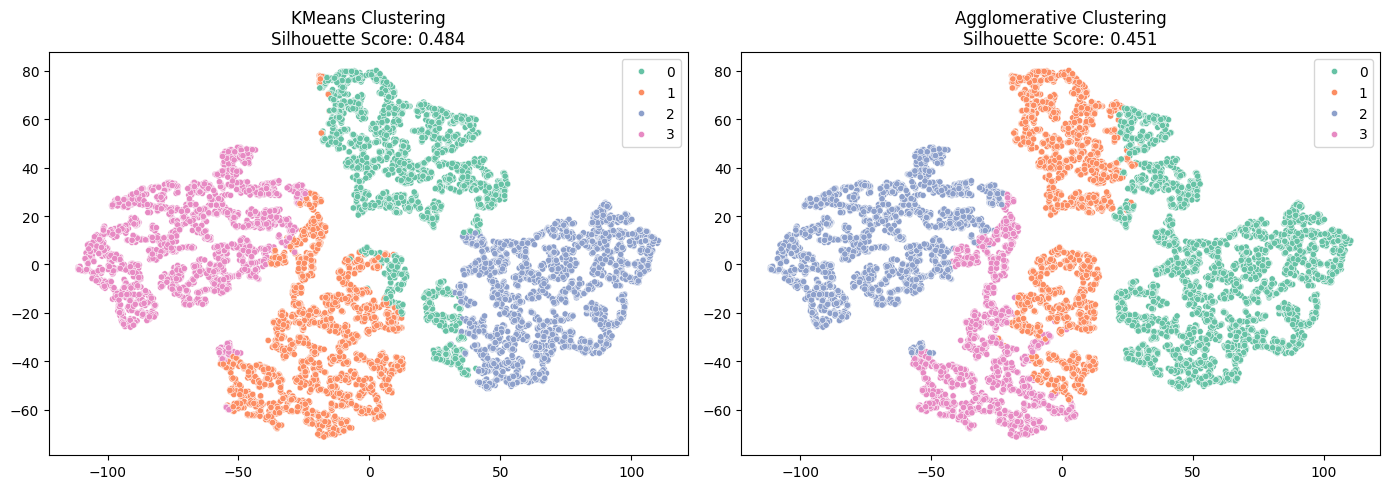

Clustering for Performance with features: ['Quiz_Scores', 'Quiz_Attempts', 'Final_Exam_Score', 'Avg_Quiz_Score_Per_Attempt']
Silhouette Score - KMeans: 0.336
Silhouette Score - Agglomerative: 0.295


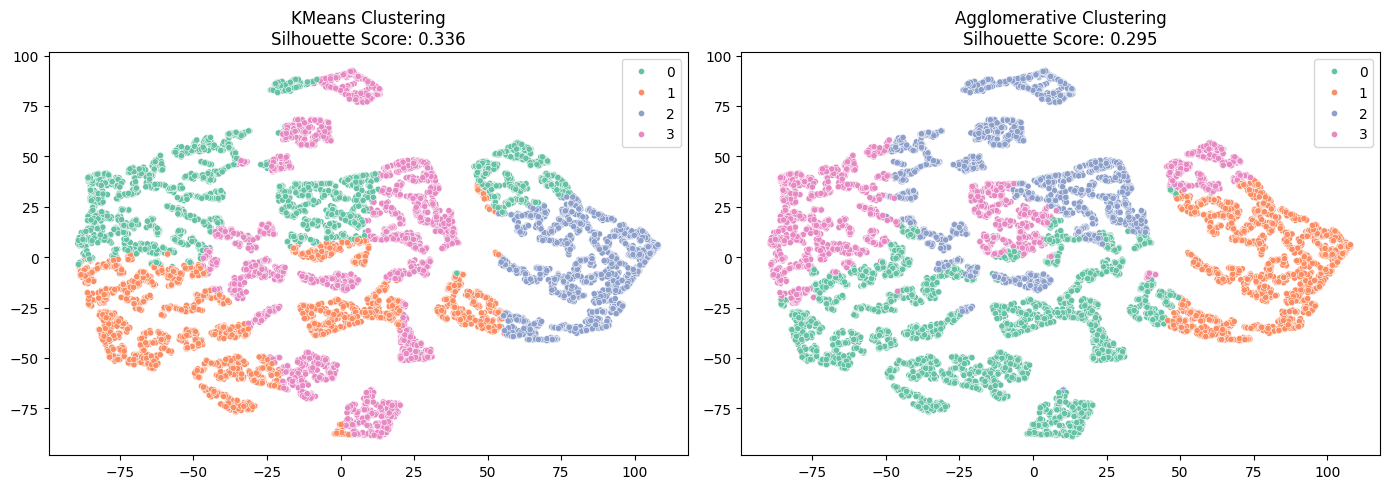

Clustering for LearningStyle_Behavior with features: ['Learning_Style', 'Time_Spent_on_Videos', 'Dropout_Likelihood', 'Feedback_Score']
Silhouette Score - KMeans: 0.568
Silhouette Score - Agglomerative: 0.538


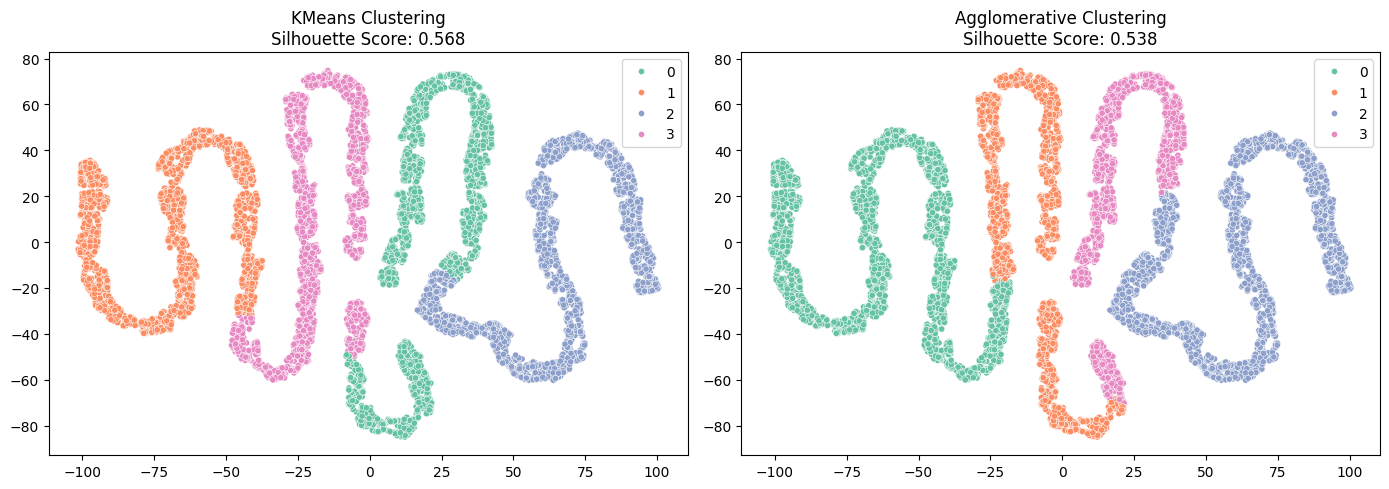

Clustering for Dropout_Risk with features: ['Dropout_Likelihood', 'Assignment_Completion_Rate', 'Quiz_Attempts', 'Feedback_Score', 'Consistency_Index']
Silhouette Score - KMeans: 0.394
Silhouette Score - Agglomerative: 0.352


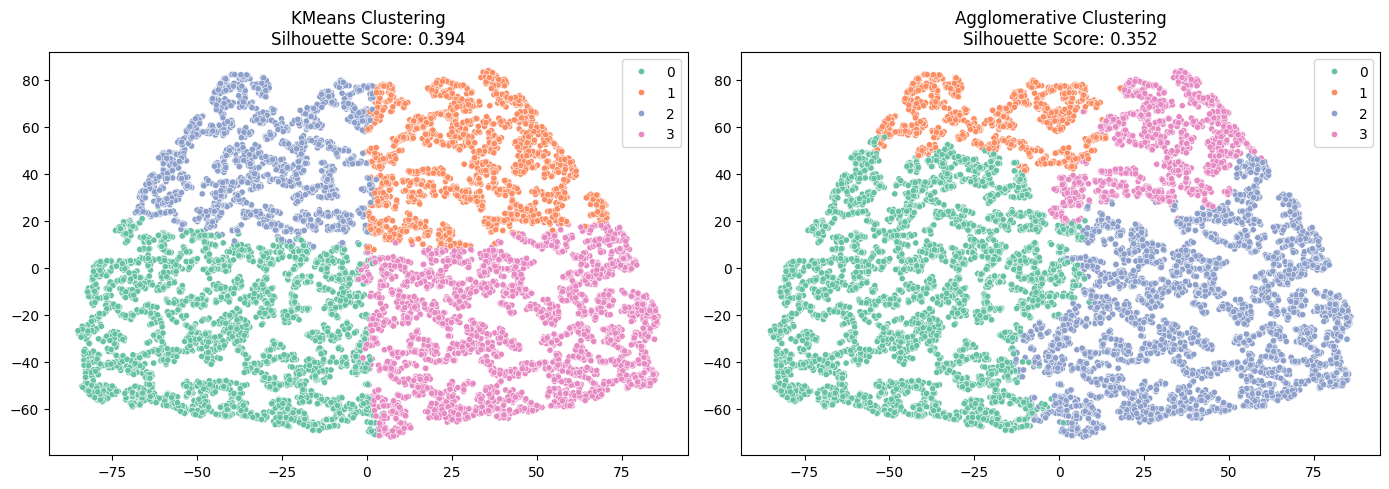

In [37]:
for cluster_name, features in cluster_configs.items():
    print(f"Clustering for {cluster_name} with features: {features}")
    clusterAndPlotAllModels(df, features)

In [38]:
result_df = df.copy()
result_df["tsneX"] = tsne_result[:, 0]
result_df["tsneY"] = tsne_result[:, 1]
result_df["KMeansClustering"] = KMeansLabels
result_df["AgglomerativeClustering"] = AgglomerativeLabels

In [39]:
def profile_clusters(df, cluster_label_column):
    cluster_profiles = df.groupby(cluster_label_column).mean(numeric_only=True)
    cluster_sizes = df[cluster_label_column].value_counts().sort_index()

    # Add cluster sizes to the profile for context
    cluster_profiles["Cluster_Size"] = cluster_sizes
    return cluster_profiles


In [40]:
kmeans_profiles = profile_clusters(result_df, "KMeansClustering")
agglom_profiles = profile_clusters(result_df, "AgglomerativeClustering")

print("KMeans Cluster Profiles:\n", kmeans_profiles)
print("Agglomerative Cluster Profiles:\n", agglom_profiles)


KMeans Cluster Profiles:
                         Age    Gender  Education_Level  Course_Name  \
KMeansClustering                                                      
0                 32.040524  0.542312         1.196265     1.976162   
1                 32.309468  0.548513         1.214789     1.963224   
2                 32.030328  0.569349         1.231298     2.005661   
3                 32.166667  0.551752         1.216789     2.001630   

                  Time_Spent_on_Videos  Quiz_Attempts  Quiz_Scores  \
KMeansClustering                                                     
0                           319.592372       2.498609    64.910608   
1                            72.028169       2.489045    64.136150   
2                           438.645370       2.502628    64.557218   
3                           195.788916       2.512225    64.720456   

                  Forum_Participation  Assignment_Completion_Rate  \
KMeansClustering                                         